# Forecasting VIX futures
Van Tassel, Peter, (2018), Relative pricing and risk premia in equity volatility markets, No 867, Staff Reports, Federal Reserve Bank of New York, https://EconPapers.repec.org/RePEc:fip:fednsr:867

The author investigates the relationship between VIX futures, variance swaps and S&P500 option prices. He builds synthetic variance swap rates using the logarithm of realized variance and S&P option prices. He then uses these to price VIX futures. He then uses this model and the mispricing to forecast VIX returns.

Evernote link: https://www.evernote.com/l/ABTp-3kFtEpHmLyzz49QkJvC_UEcvf-Vybo


In [1]:
from pathlib import Path   
import pandas as pd
import numpy as np
import pyfolio as pf
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as bbox
from matplotlib import rcParams
import seaborn as sns

import pandas_datareader as web
from scipy.io import loadmat
import quandl
import nest_asyncio

import sys
import socket
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

if socket.gethostname() == 'edmunds-mbp.lan':
    %config InlineBackend.figure_format = 'retina'

from option_utilities import perf_stats, matlab2datetime, grid_ticks_format, \
     invisible_spines, color_axis, PlotConstants
from option_simulation import OptionSimulation, plot_performance_quad, OptionTrades
from spx_data_update import quandle_api, ImpliedVolatilityHistory, VixTSM
from implied_to_realized import SPX5MinuteBars

nest_asyncio.apply()
pc = PlotConstants()

In [2]:
vx = VixTSM()
iv_hist = ImpliedVolatilityHistory()
VIX = iv_hist.implied_vol_index
contract_month = range(1, 10)
vix_list = []
for month in contract_month:
    vix_fut = quandl.get('CHRIS/CBOE_VX{}'.format(month),  collapse='daily')
    vix_fut = vix_fut['Close']
    vix_fut[:'2007-03-23'] = vix_fut[:'2007-03-23'] / 10
    print('Month {0} Contracts replaced {1}'.format(month, sum(vix_fut == 0)))
    vix_fut = vix_fut.replace(to_replace=0, method='ffill')
    vix_fut = vix_fut.rename('Month{}'.format(month))
    vix_list.append(vix_fut)
vix_all = pd.concat(vix_list, axis=1)
bars = SPX5MinuteBars(update_bars=True)

opt_sim = OptionSimulation(update_simulation_data=False)
z_score = -1
duration = 2
leverage = 2
sim_idx = 0
%time sim_output = [opt_sim.trade_sim(z_score, duration, trade_day_type=day_type) \
                    for day_type in ['EOM']]
opt_trade = [OptionTrades(sim, leverage=leverage) for sim in sim_output]

Month 1 Contracts replaced 4
Month 2 Contracts replaced 4
Month 3 Contracts replaced 0
Month 4 Contracts replaced 0
Month 5 Contracts replaced 0
Month 6 Contracts replaced 0
Month 7 Contracts replaced 0
Month 8 Contracts replaced 0
Month 9 Contracts replaced 58
Running Simulation - trade_day_type:EOM | Z-score -1 | Duration 2 | Option Type:P
CPU times: user 39 s, sys: 2.34 s, total: 41.3 s
Wall time: 38.6 s


In [3]:
vix_idx_long = vx.vix_idx_long
vix_idx_short = vx.vix_idx_short
vix_ret_short = vx.vix_ret_short.dropna()
opt_vega = pd.concat([opt_trade[sim_idx].returns['2004-04-07':'2014-04-03'], vix_ret_short], axis=1)
opt_vega.corr()

,EOMP-1L2.0,contract0vega10bpsS
EOMP-1L2.0,1.00000,0.72036
contract0vega10bpsS,0.72036,1.00000


/Users/ebellord/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/ebellord/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/ebellord/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


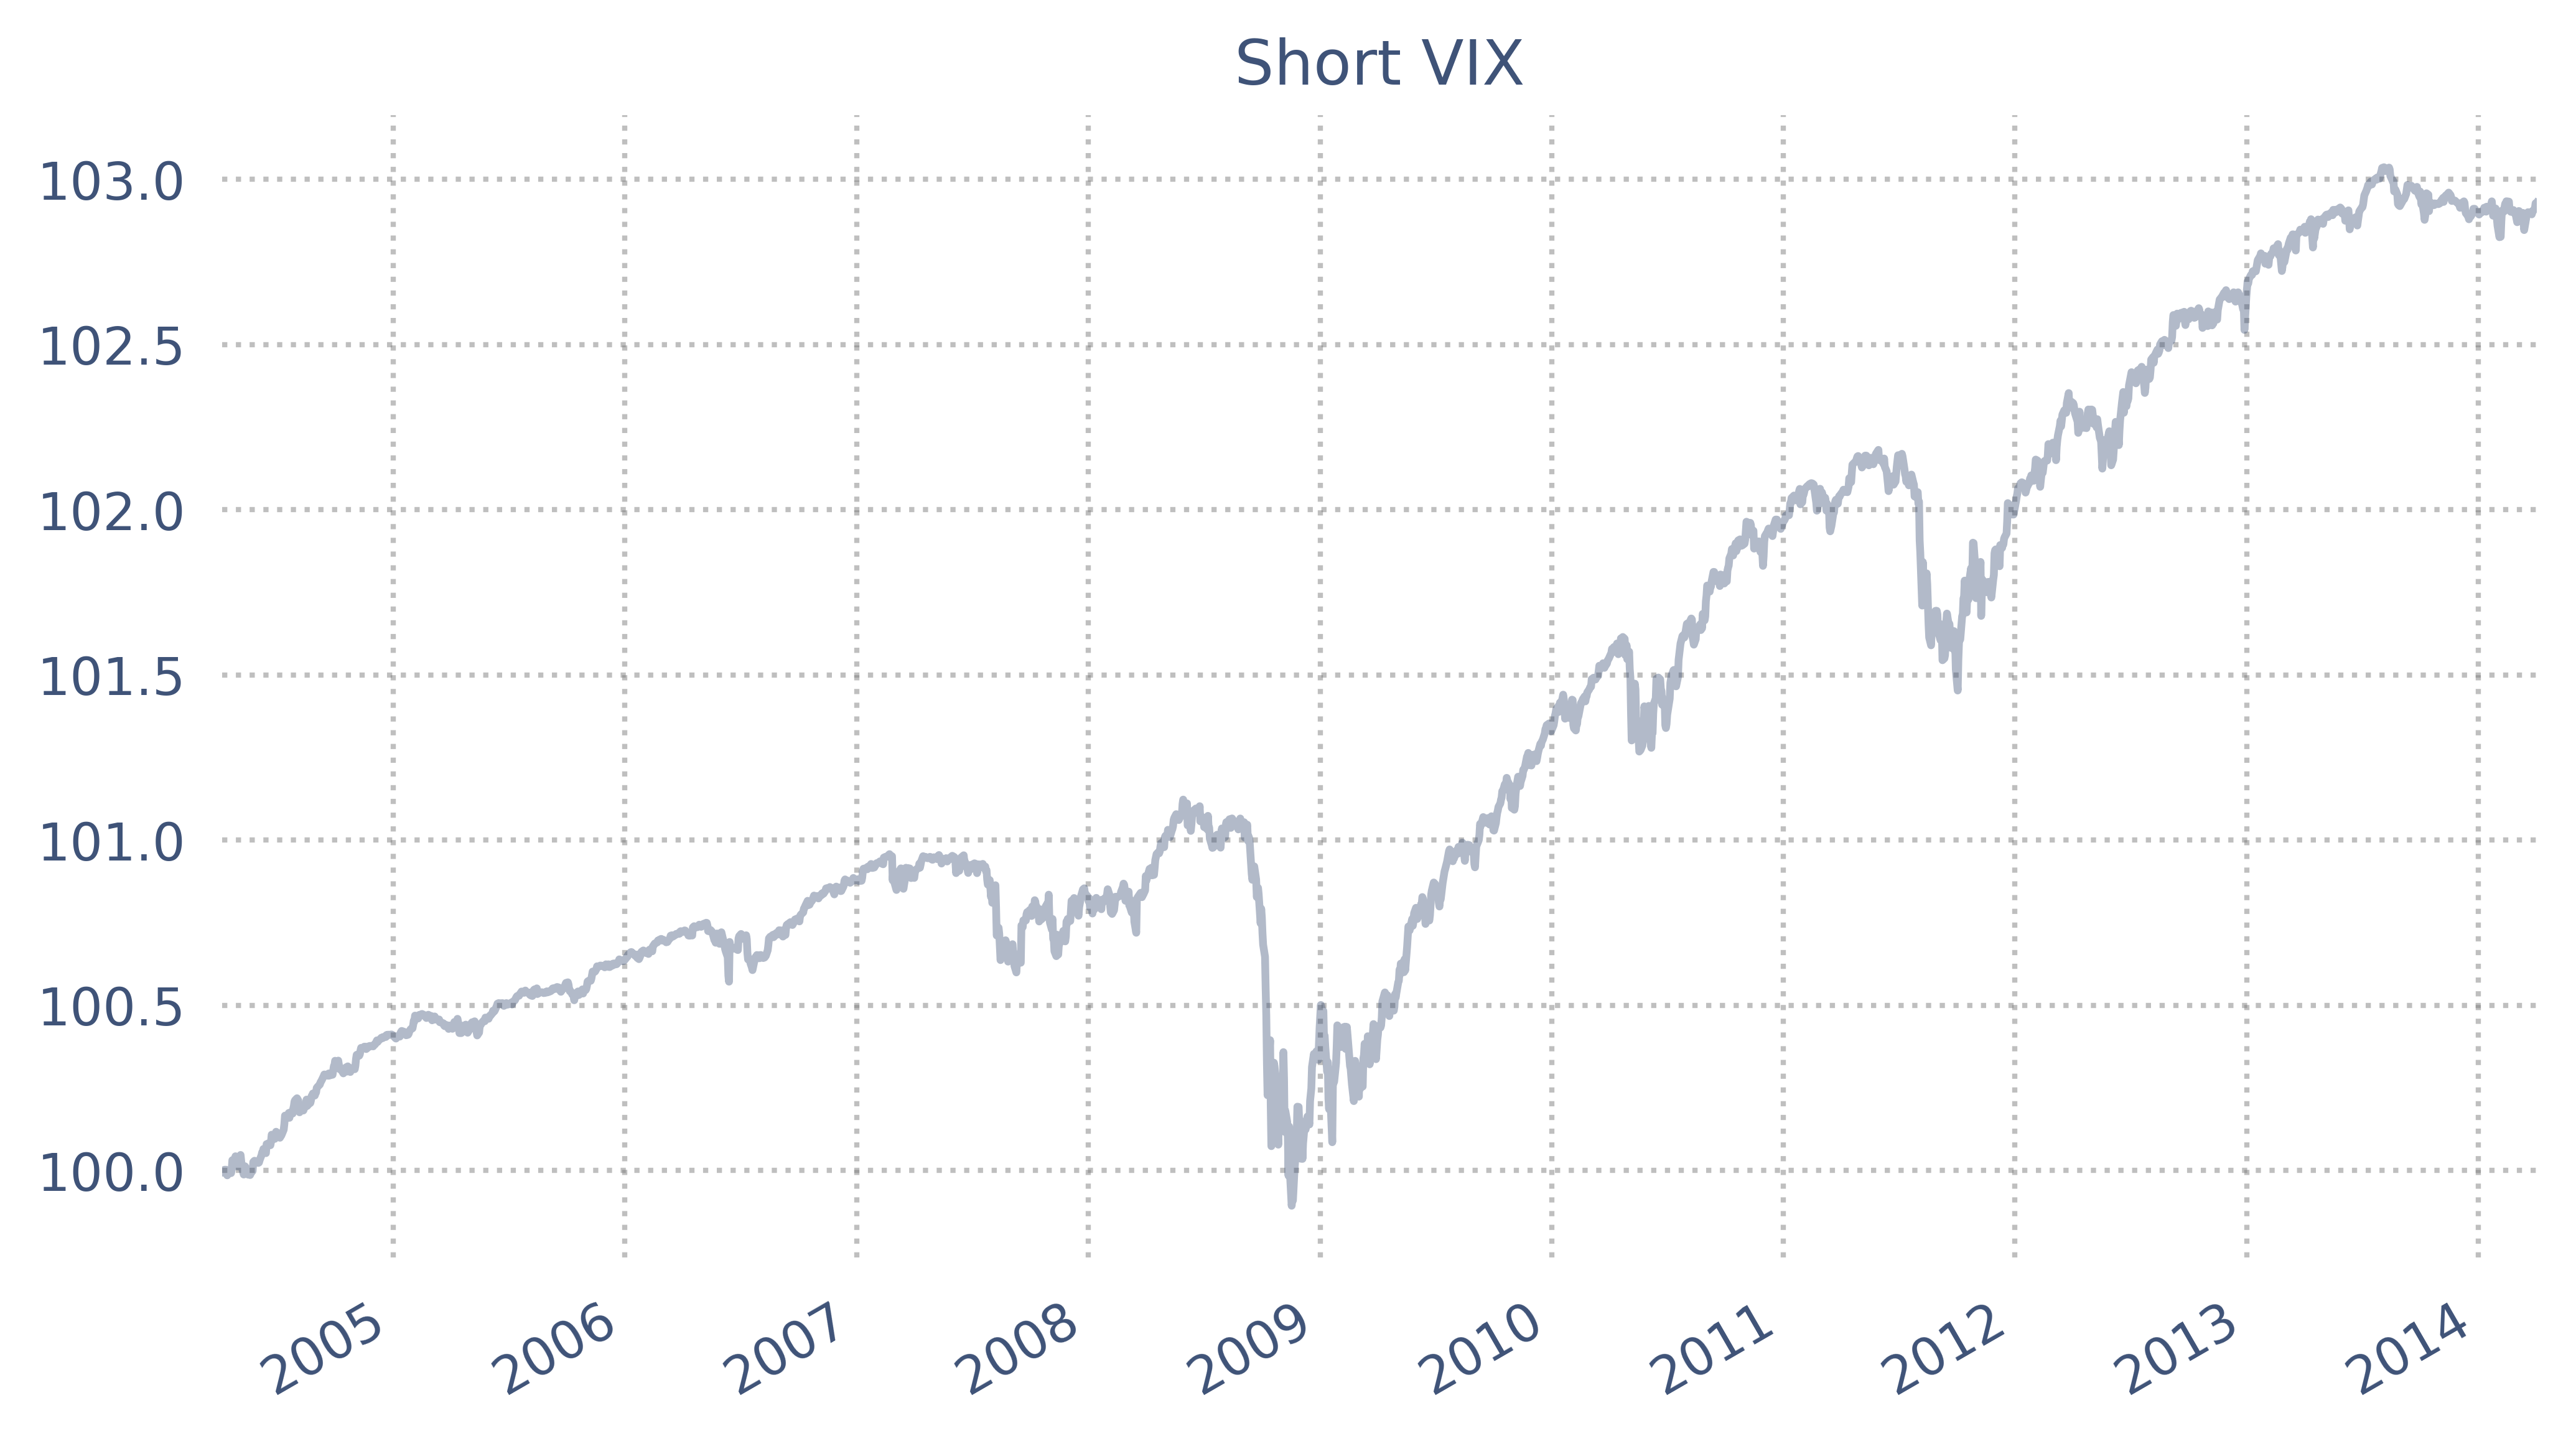

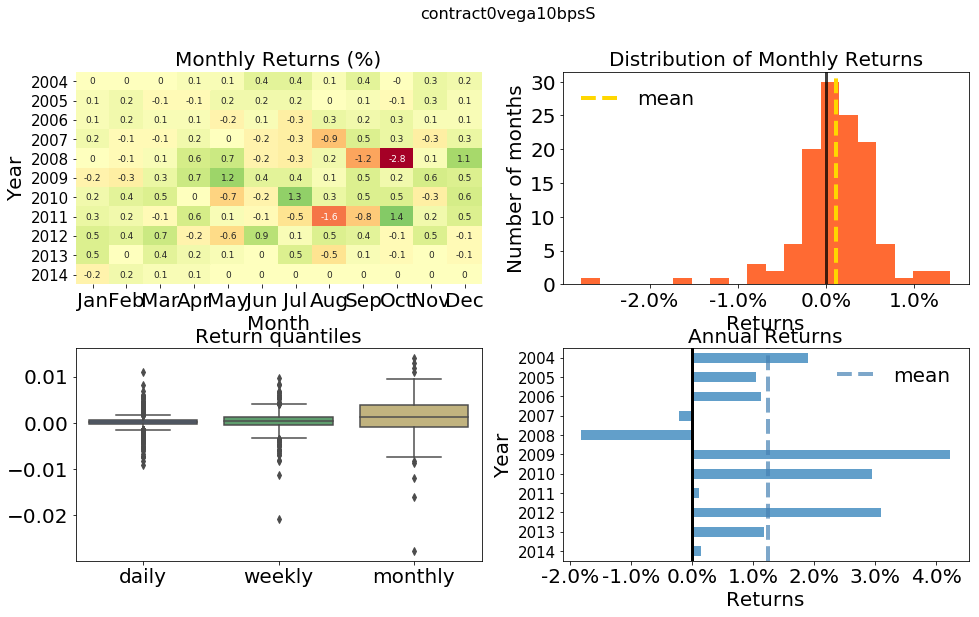

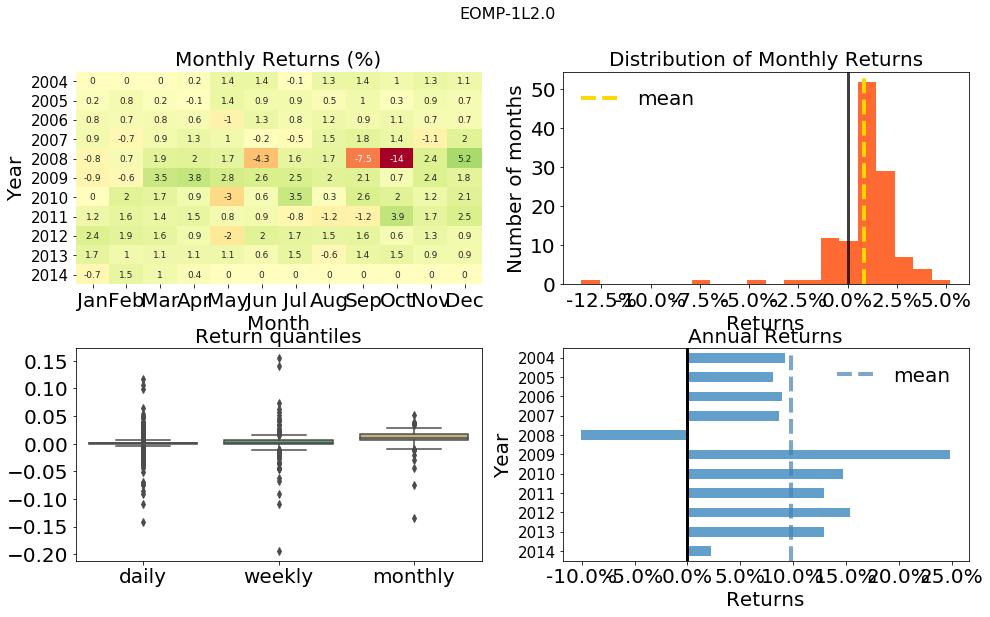

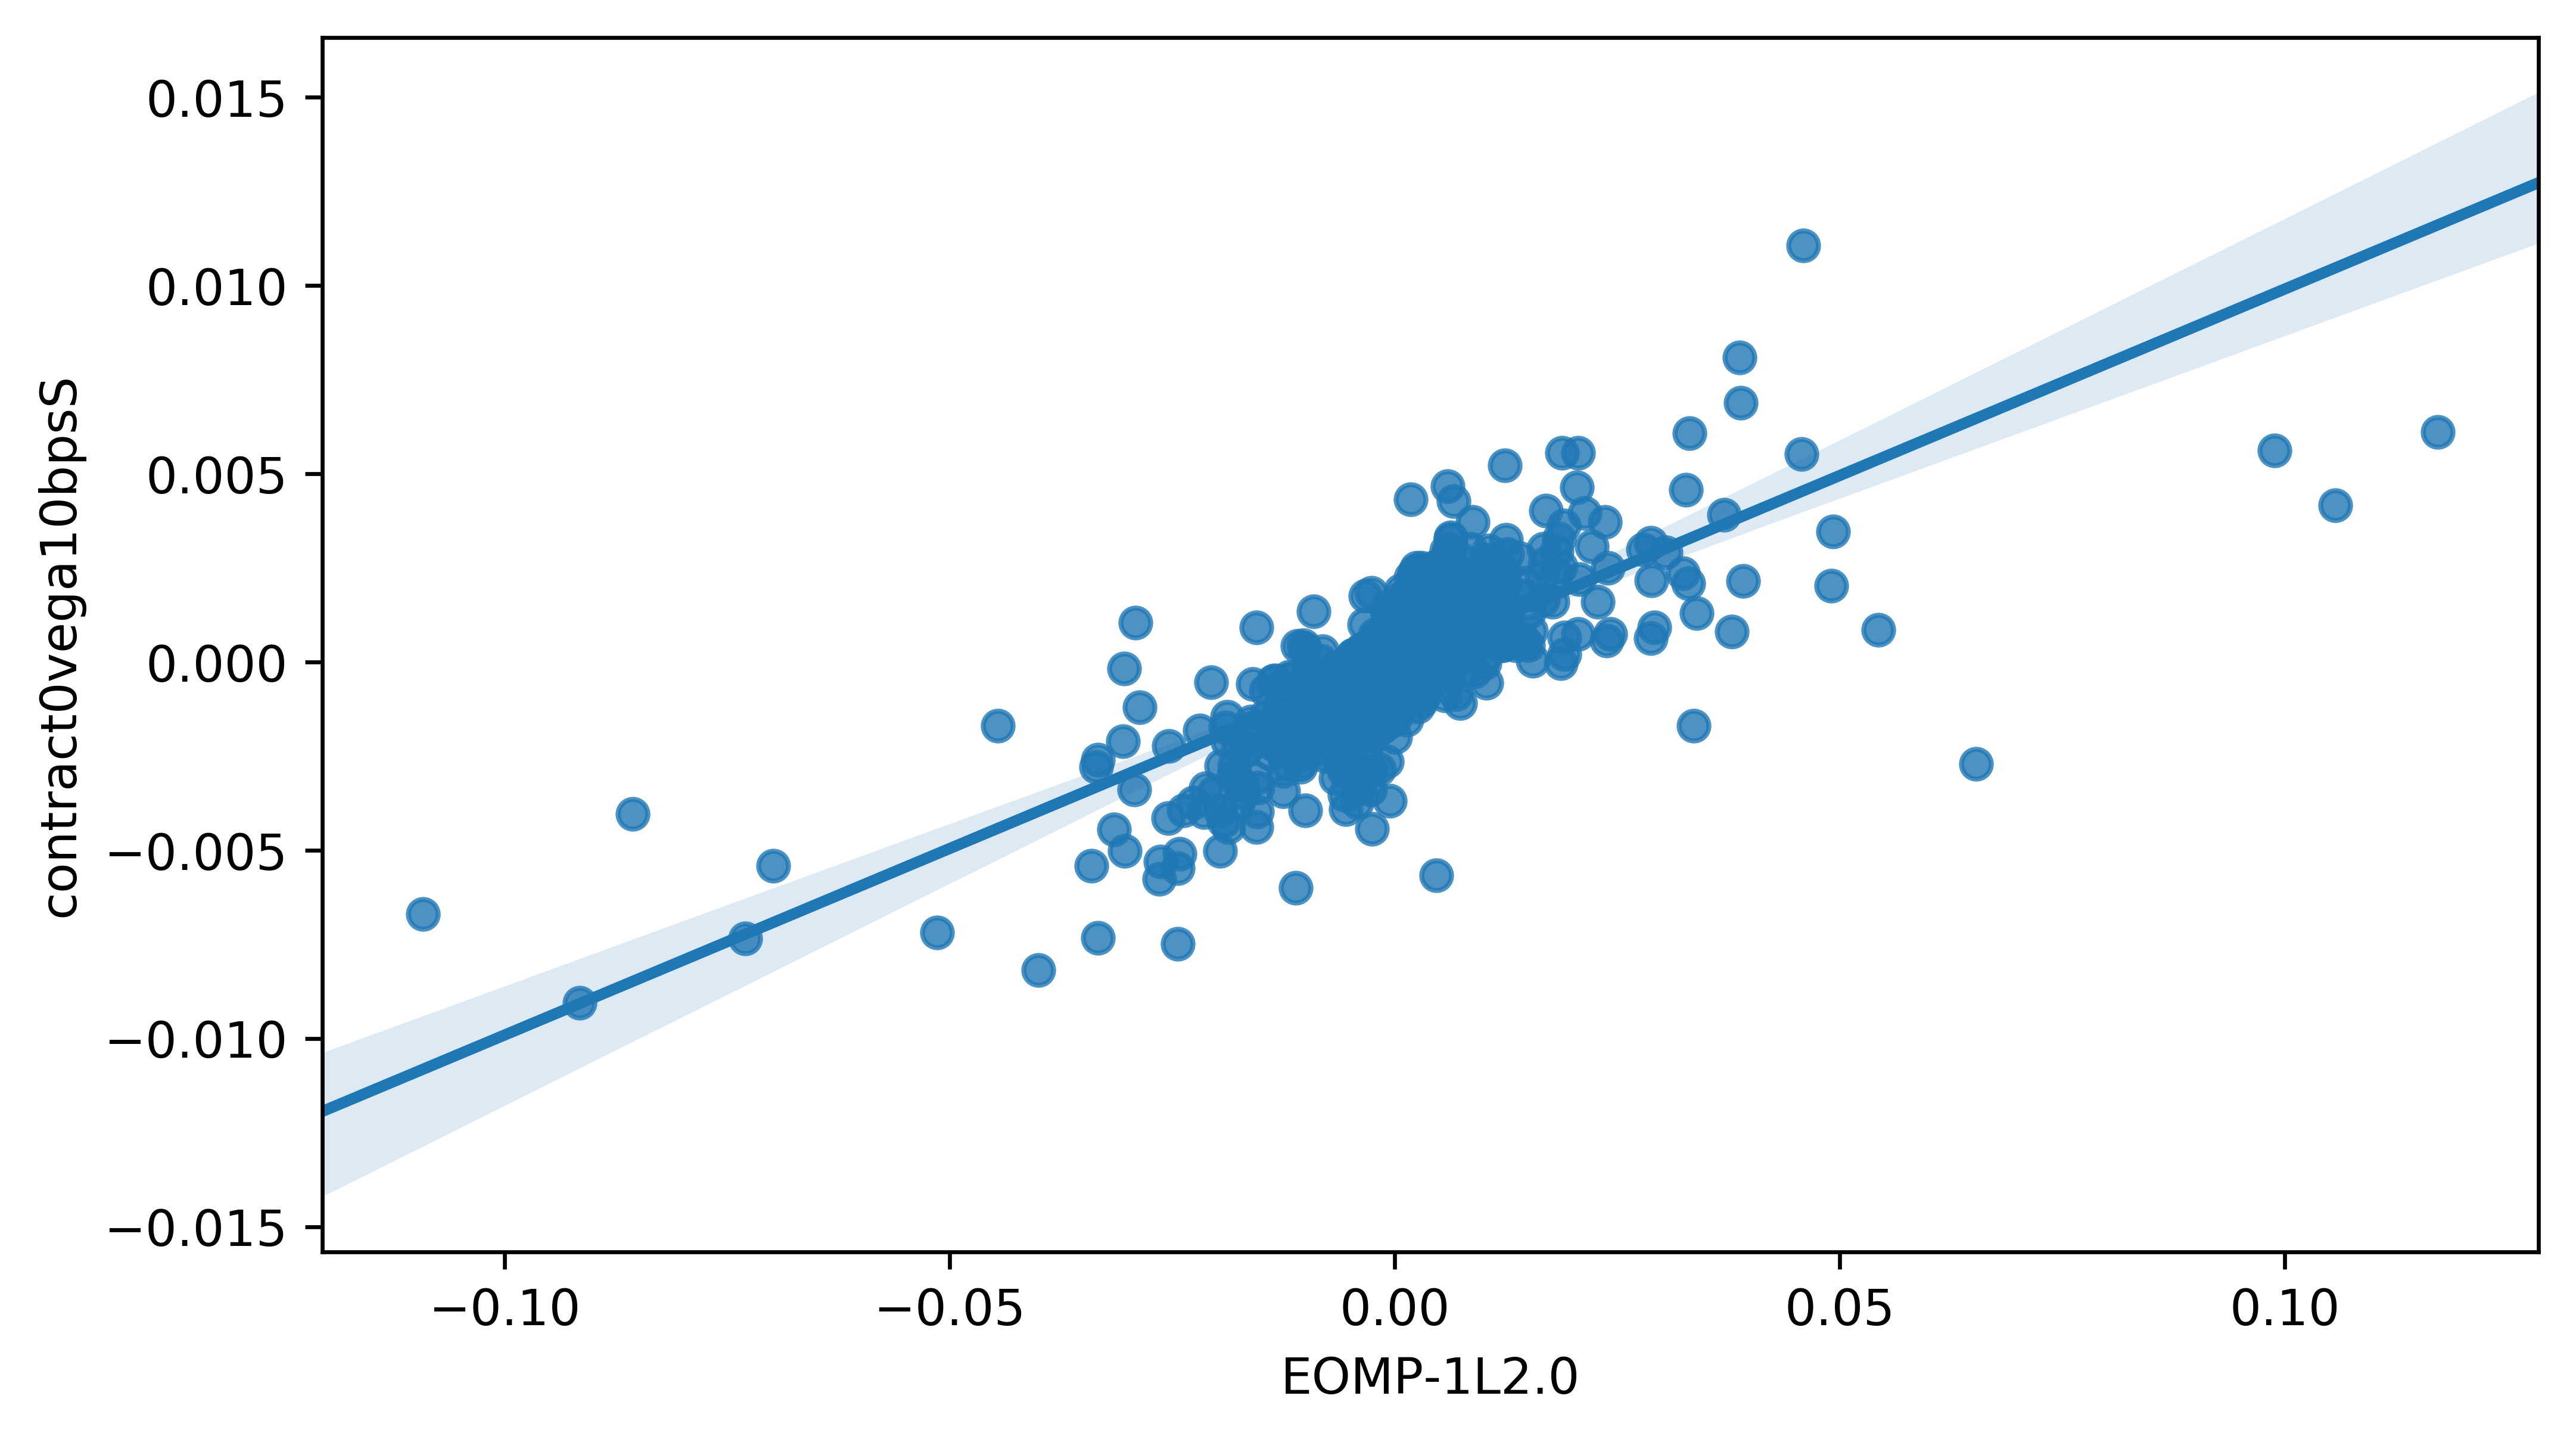

In [4]:
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_vix = plt.subplot(gs[:])
vix_idx_short_log = np.log(vix_idx_short)

vix_idx_short_log = vix_idx_short_log / vix_idx_short_log[0] * 100
ax_vix = vix_idx_short_log.plot(color=pc.color_light, lw=1.5
                       ,ax=ax_vix, grid=True, alpha=0.4,
                       title ='Short VIX')
grid_ticks_format([ax_vix])
color_axis(ax_vix, pc.color_light)
invisible_spines(ax_vix)
plt.autoscale(enable=True,
              axis='x',
              tight=True)
fig.tight_layout(pad=0)
plot_performance_quad(vix_ret_short)
plot_performance_quad(opt_trade[sim_idx].returns['2004-04-07':'2014-04-03'])

fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
_= sns.regplot(opt_vega.columns[0], opt_vega.columns[1], data=opt_vega)

In [5]:
pd.concat([perf_stats(opt_vega.sum(axis=1)), 
           perf_stats(vix_ret_short), 
           perf_stats(opt_trade[sim_idx].returns['2004-04-07':'2014-04-03'])], axis=1)



,0,contract0vega10bpsS,EOMP-1L2.0
StartDate,"Apr 07, 2004","Apr 07, 2004","Apr 07, 2004"
EndDate,"Apr 03, 2014","Apr 03, 2014","Apr 03, 2014"
annual_return,0.11782,0.0142676,0.104853
annual_volatility,0.160194,0.0191163,0.14717
sharpe_ratio,0.776468,0.750821,0.752154
calmar_ratio,0.323624,0.259255,0.317714
stability_of_timeseries,0.960821,0.925321,0.966512
max_drawdown,-0.364064,-0.0550331,-0.330024
omega_ratio,1.24499,1.17272,1.25318
sortino_ratio,1.06458,1.03272,1.02994


# Compare VIX futures and VXX & VXXB
VXX is legacy ETF (now replaced by VXXB). Unlike the future strategy the E

TF rebalances to constant vega exposure every day. In addition the ETF is fully collateralized whereas the future is just excess returns.

,Adj Close,contract0vega10bpsS
StartDate,"Feb 03, 2009","Feb 03, 2009"
EndDate,"Apr 03, 2014","Apr 03, 2014"
annual_return,1.81952,0.02424
annual_volatility,0.616571,0.0190129
sharpe_ratio,1.9961,1.26979
calmar_ratio,2.81573,0.734995
stability_of_timeseries,0.983376,0.960055
max_drawdown,-0.6462,-0.0329799
omega_ratio,1.40242,1.26823
sortino_ratio,2.93406,1.76648


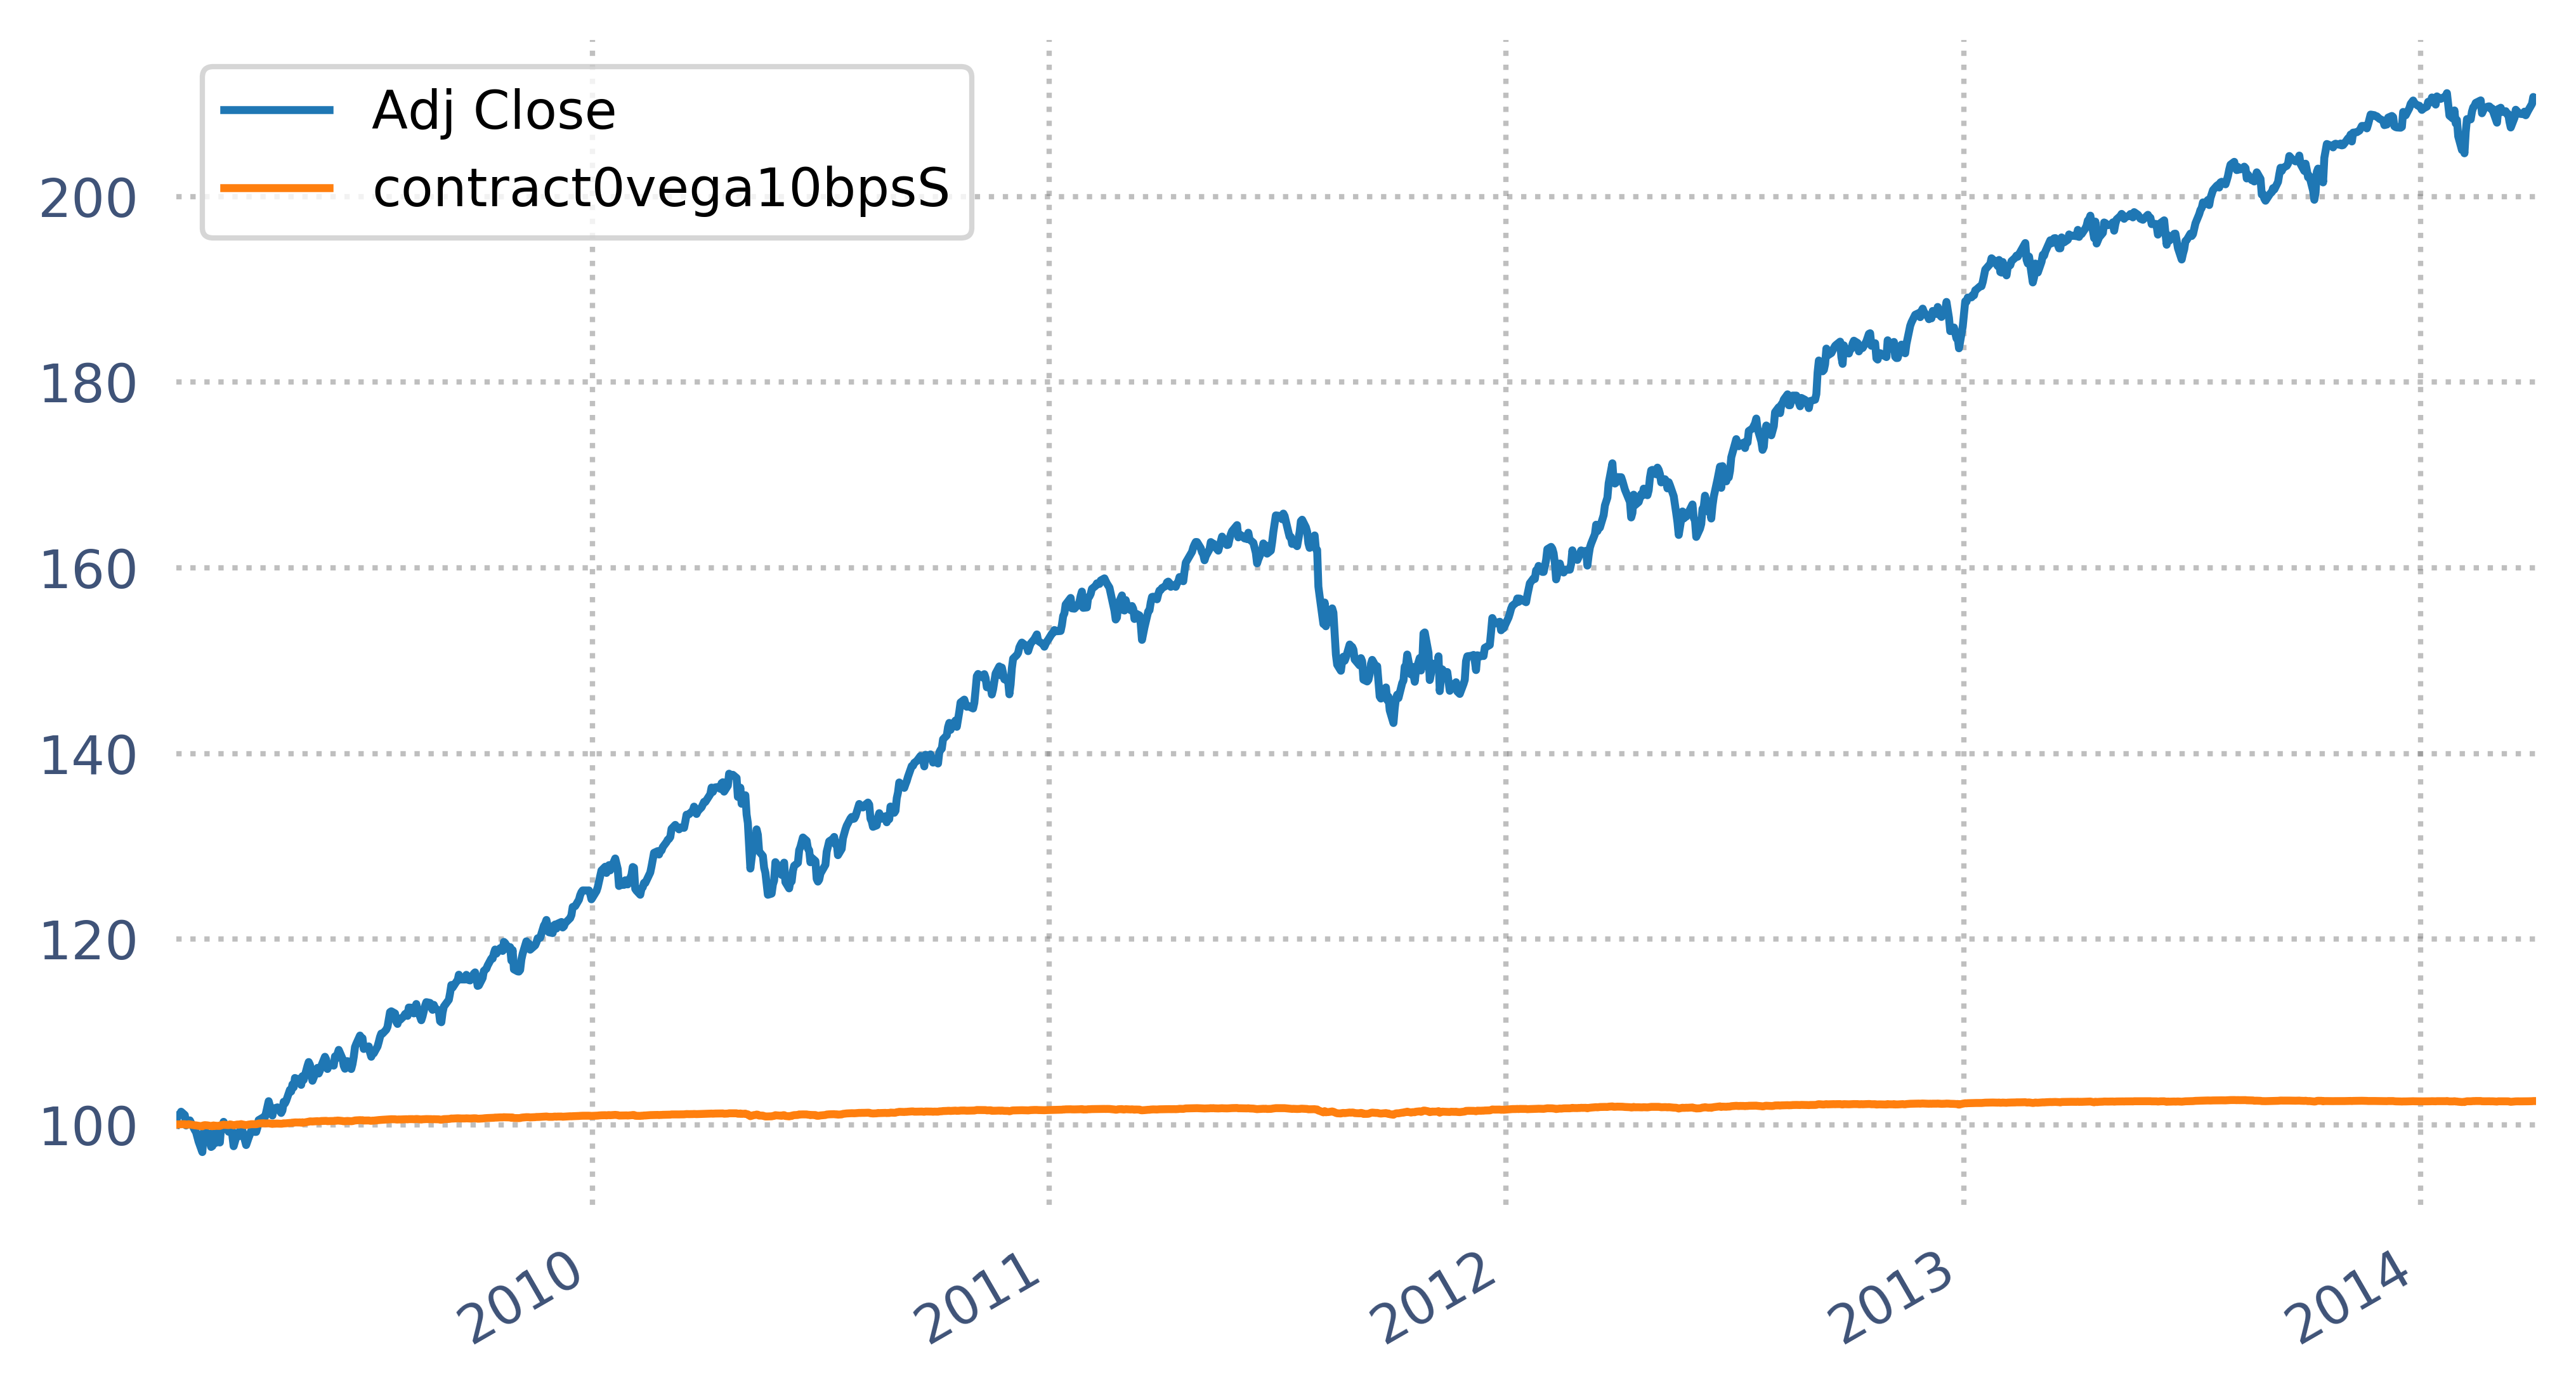

In [6]:
# Splice returns from current (VXXB) and legacy (VXX) ETF
VXX = [web.get_data_yahoo(item, 'JAN-01-90') for item in ['VXX', 'VXXB']]
VXX_ret = [item['Adj Close'].pct_change().dropna(how='any') for item in VXX]
full_hist = VXX_ret[1].combine_first(VXX_ret[0])
etf_idx = pf.timeseries.cum_returns(full_hist, 100)
etf_short_idx = 1 / etf_idx

shared_dates = etf_short_idx.index.intersection(vix_idx_short.index)

etf_perf = perf_stats(etf_short_idx.reindex(shared_dates).pct_change().dropna(how='any'))
fut_perf = perf_stats(vix_idx_short.reindex(shared_dates).pct_change().dropna(how='any'))
display(pd.concat([etf_perf, fut_perf], axis=1))
compare= pd.concat([etf_short_idx, vix_idx_short], axis=1).dropna(how='any')
compare = compare / compare.iloc[0,:] *100
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_plt = plt.subplot(gs[:])
compare_log = np.log(compare)
compare_log = compare_log / compare_log.iloc[0, :] * 100
ax_vix = compare_log.plot(ax=ax_plt)
grid_ticks_format([ax_vix])
color_axis(ax_vix, pc.color_light)
invisible_spines(ax_vix)
plt.autoscale(enable=True,
              axis='x',
              tight=True)

# Splice VIX futures history with VIX ETF
Not great but it's all we have so far

StartDate                  Apr 07, 2004
EndDate                    Feb 07, 2019
annual_return                   0.73352
annual_volatility              0.507852
sharpe_ratio                    1.34213
calmar_ratio                    1.13513
stability_of_timeseries        0.971265
max_drawdown                    -0.6462
omega_ratio                     1.32205
sortino_ratio                   1.91207
skew                          -0.588313
kurtosis                        5.63934
tail_ratio                      1.03094
Name: Adj Close, dtype: object

/Users/ebellord/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


,net drawdown in %,peak date,valley date,recovery date,duration
0,64.62,2011-07-07,2011-10-03,2012-03-20,184
1,53.4408,2018-01-11,2018-02-08,NaT,NaN
2,49.3823,2015-08-10,2015-09-01,2016-04-27,188
3,46.3751,2010-04-20,2010-05-20,2010-09-13,105
4,32.6308,2014-07-03,2014-10-16,2014-11-25,104
5,30.6023,2012-03-26,2012-06-01,2012-06-29,70
6,29.2107,2014-12-05,2015-01-30,2015-03-20,76
7,26.3088,2011-02-14,2011-03-16,2011-04-15,45
8,25.8029,2014-01-22,2014-02-05,2014-05-05,74
9,23.5888,2016-06-06,2016-06-24,2016-07-08,25


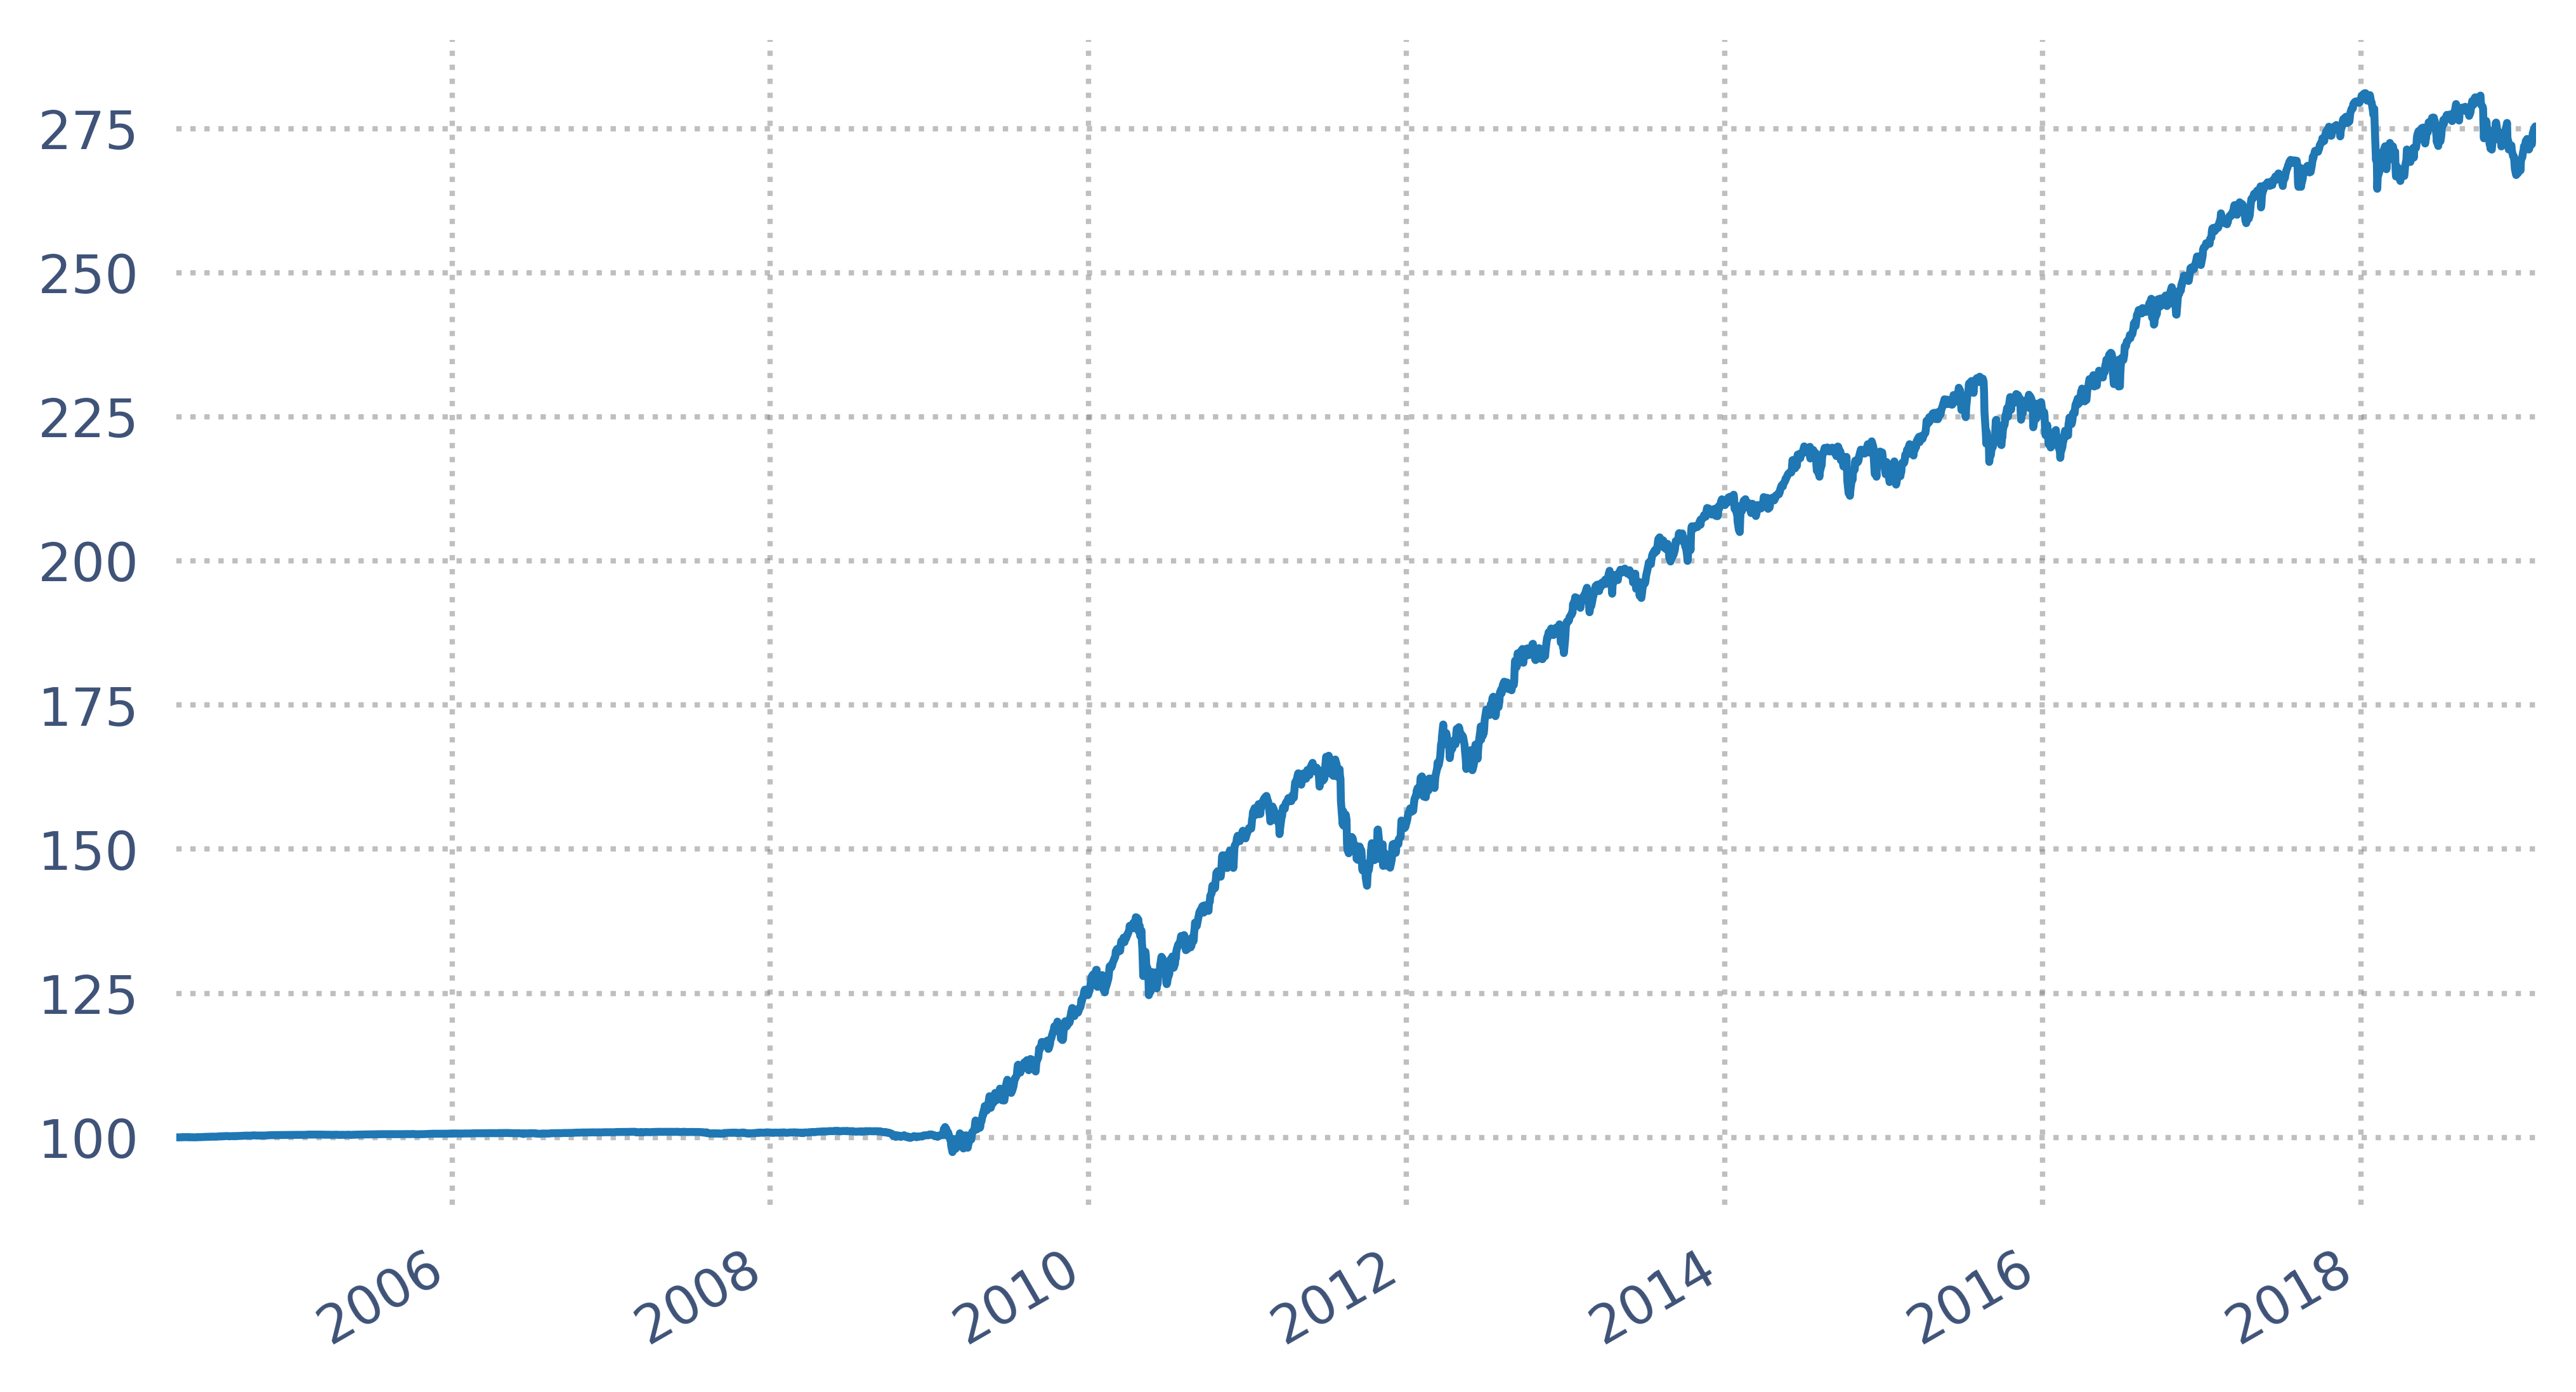

In [7]:
vix_ret_hist = etf_short_idx.pct_change().dropna(how='any').combine_first(vix_ret_short)
vix_ret_hist.to_frame().style

vix_idx_hist = pf.timeseries.cum_returns(vix_ret_hist, 100)

fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_hist = plt.subplot(gs[:])
vix_idx_hist_log = np.log(vix_idx_hist)
vix_idx_hist_log = vix_idx_hist_log / vix_idx_hist_log[0] * 100

ax_hist = vix_idx_hist_log.plot(ax=ax_hist)
display(perf_stats(vix_ret_hist))
display(pf.timeseries.gen_drawdown_table(vix_ret_hist))
grid_ticks_format([ax_hist])
color_axis(ax_hist, pc.color_light)
invisible_spines(ax_hist)
plt.autoscale(enable=True,
              axis='x',
              tight=True)

In [8]:
slope = vix_all[vix_all.columns[2]] - vix_all[vix_all.columns[0]]
level_premium = vix_all[vix_all.columns[0]] - VIX

In [9]:
slope = slope['2005-12-22':].dropna(how='any')
level_premium = level_premium['2005-12-22':].dropna(how='any')
realized_variance = bars.realized_variance
Y, X_slope, X_level, X_vix, X_RV = [item.resample('BM', closed='left').ffill().dropna() for item in
                              [vix_idx_hist, 
                               slope, level_premium , 
                               VIX, 
                               realized_variance]]

Y = Y.pct_change().dropna(how='any')

Y, X_slope, X_level, X_vix, X_RV = [item.rename(name) for item, 
                                    name in zip([Y, X_slope, X_level, X_vix, X_RV],
                                                ['Y', 'X_slope', 'X_level', 'X_vix', 'X_RV'])]
regression_data = pd.concat([Y, X_slope.shift(1), X_level.shift(1), \
                             X_vix.shift(1), X_RV.shift(1)], axis=1)
regression_data = regression_data.dropna(axis=0, how='any')


regression_string = 'Y ~ X_level + X_slope + X_vix'
results = sm.ols(formula=regression_string, data=regression_data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.941
Date:                Thu, 07 Feb 2019   Prob (F-statistic):            0.00975
Time:                        15:29:50   Log-Likelihood:                 69.200
No. Observations:                 147   AIC:                            -130.4
Df Residuals:                     143   BIC:                            -118.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0605      0.049     -1.240      0.217      -0.157       0.036
X_level        0.0253      0.011      2.332      0.021       0.004       0.047
X_slope        0.0098      0.009      1.108      0.270      -0.008       0.027
X_vix          0.0053      0.002      2.607      0.010       0.001       0.009
==============================================================================
Omnibus:                        1.882   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.439
Skew:                          -0.152   Prob(JB):                        0.487
Kurtosis:                       3.378   Cond. No.                         83.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

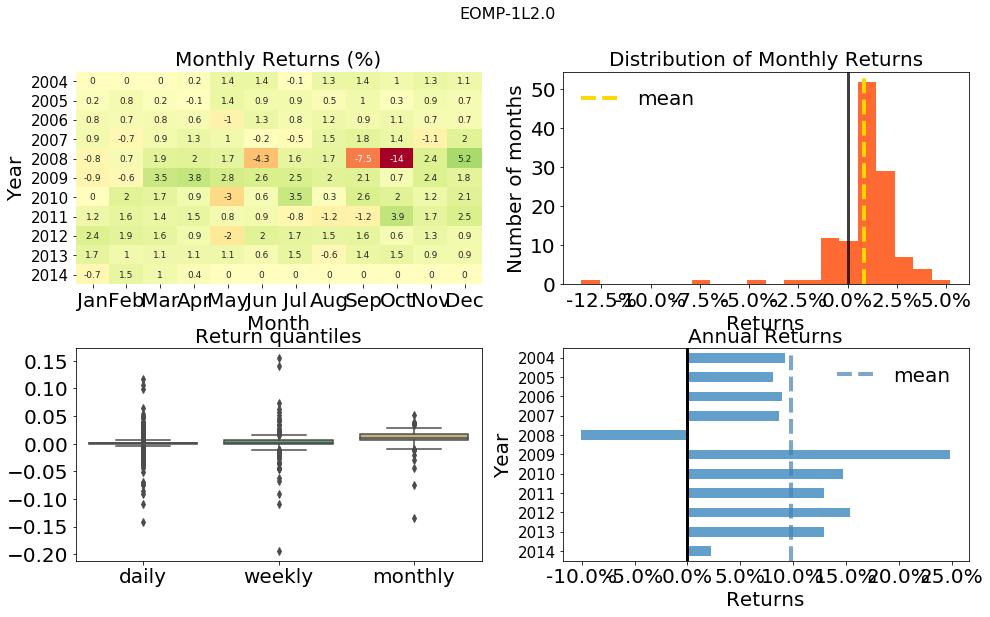

In [10]:
plot_performance_quad(opt_trade[sim_idx].returns['2004-04-07':'2014-04-03'])
# vix_ret_short.index
# opt_trade[sim_idx].returns.reindex(vix_ret_short.index).index